In [1]:
# Import List
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline  

In [2]:
# Camera Calibrate Function
def CamCali():
        objpoints = []
        imgpoints = []
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        for name in glob.glob('camera_cal/*'):
            img = mpimg.imread(name)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)     
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)
                        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        return (mtx,dist)

# Undistort Image
def imgund(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# BGR to RGB
def colorspacec(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
# Binary Image Creator
def BinaryIC(img,thresh):
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary
    
# HLS Thresholding
def hls_select(img,channel = 0 ,thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img = hls[:,:,channel]
    return BinaryIC(img,thresh)

# Gradient Thresholding
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return BinaryIC(scaled_sobel,thresh)

# Gradient Magnitude Thresholding
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobelxy = np.sqrt(sobelx*sobelx +sobely*sobely)
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    return BinaryIC(scaled_sobel,thresh)

# Gradient Direction Thresholding
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    direction_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return BinaryIC(direction_sobel,thresh)

# Color Thresholding
def color_thresh(img, color_channel =0 , thresh = (200, 255)):
    color_c = img[:,:,color_channel]
    return BinaryIC(color_c,thresh)

# Plot function
def alfplot(img):
    plt.imshow(img,'gray')
    plt.grid()

# Region of Interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Perspective Image Transform
def pit(img):
    src = np.float32([[565,480], [707,480], [925,720], [300,720]])
    dst = np.float32([[315,200], [885,200], [850,720], [335,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

# Color threshold combining
def comb_color(img):
    comb = np.zeros_like(img[:,:,2])
    comb[(color_thresh(img,0,(200,255))==1) | (color_thresh(img,2,(200,255))==1) | (color_thresh(img,2,(200,255))==1) ] = 1
    return comb

# Thresholding and Combining Thresholds

def combined(img):
    comb = np.zeros_like(img[:,:,2])
    comb[((hls_select(img,2,(150,200))==1) & (color_thresh(img,2,(100,200))==1)) | (((abs_sobel_thresh(img,'x',(20,120))==1) & (dir_thresh(img,5,(.3,1.1))==1)) & (color_thresh(img,2,(150,255))==1)) ] = 1
    return comb

# Finding Histogram
def hist(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)
 
# Histogram Information
def histinfo(hist):
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    return (midpoint, leftx_base, rightx_base)


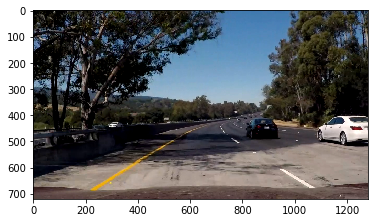

In [3]:
clip1 = VideoFileClip("project_video.mp4")
vid_clip = clip1.get_frame(41.4)
plt.imshow(vid_clip)


In [4]:
vid_output = 'project_video_short_1.mp4'
clip1 = VideoFileClip("project_video.mp4")
vid_clip = clip1.subclip(35) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_short_1.mp4
[MoviePy] Writing video project_video_short_1.mp4


100%|██████████| 385/385 [00:06<00:00, 55.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_short_1.mp4 

CPU times: user 543 ms, sys: 498 ms, total: 1.04 s
Wall time: 7.78 s


[MoviePy] >>>> Building video outputvideo6.mp4
[MoviePy] Writing video outputvideo6.mp4



 24%|██▍       | 303/1261 [00:52<02:48,  5.68it/s]


 48%|████▊     | 605/1261 [01:48<01:59,  5.47it/s]


 72%|███████▏  | 907/1261 [02:43<01:09,  5.11it/s]


 83%|████████▎ | 1042/1261 [03:09<00:42,  5.19it/s]

TypeError: expected non-empty vector for x

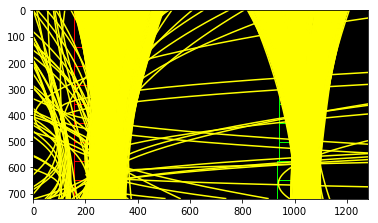

In [60]:
vid_output1 = 'outputvideo6.mp4'
clip2 = VideoFileClip("project_video.mp4")
vid_clip = clip2.fl_image(adlafi) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output1, audio=False)

In [15]:
imag = cv2.imread('test_images/test6.jpg')
mtx = CamCali()[0]
dist = CamCali()[1]

In [48]:
def frame_process_window(imag):
    imag = pit(combined(imgund(imag,mtx,dist)))
    nwindows = 10 # Number of windows
    margin = 75 # Half Width of window
    minpix = 50 # Min pix to recentre
    window_height = np.int(imag.shape[0]/nwindows) # Window height
   # Finding non-zero pixels
    nonzero = imag.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = histinfo(hist(imag))[1]
    rightx_current = histinfo(hist(imag))[2]
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((imag, imag, imag))*255
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = imag.shape[0] - (window+1)*window_height
        win_y_high = imag.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #print(len(good_left_inds))
        #print(len(good_right_inds))
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return (left_lane_inds,right_lane_inds,nonzerox,nonzeroy,out_img,imag)

def linedata(frameprocwin):
    # Extract left and right line pixel positions
    leftx = frameprocwin[2][frameprocwin[0]]
    lefty = frameprocwin[3][frameprocwin[0]] 
    rightx = frameprocwin[2][frameprocwin[1]]
    righty = frameprocwin[3][frameprocwin[1]] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, imag.shape[0]-1, imag.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.figure(2)
    frameprocwin[4][frameprocwin[3][frameprocwin[0]], frameprocwin[2][frameprocwin[0]]] = (0,255,0)
    frameprocwin[4][frameprocwin[3][frameprocwin[1]], frameprocwin[2][frameprocwin[1]]] = (255,0,0)
    plt.imshow(frameprocwin[4],'gray')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return (left_fitx,right_fitx,left_fit,right_fit)
    
def linecheck(lindat,img):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([lindat[0], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lindat[1], ploty])))])
    pts = np.hstack((pts_left, pts_right))
    return pts

def curvature(lindat,imag,frameprocwin):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, imag.shape[0]-1, imag.shape[0] )
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*lindat[2][0]*y_eval + lindat[2][1])**2)**1.5) / np.absolute(2*lindat[2][0])
    right_curverad = ((1 + (2*lindat[3][0]*y_eval + lindat[3][1])**2)**1.5) / np.absolute(2*lindat[3][0])

    # Example values: 1926.74 1908.48
    
        # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = frameprocwin[2][frameprocwin[0]]
    lefty = frameprocwin[3][frameprocwin[0]] 
    rightx = frameprocwin[2][frameprocwin[1]]
    righty = frameprocwin[3][frameprocwin[1]] 
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    # Example values: 632.1 m    626.2 m
    avracur = (left_curverad +right_curverad)/2.0
    return (avracur,left_curverad, right_curverad,left_curverad, right_curverad)

def finalimg(imag,linec):
    warp_zero = np.zeros_like(imag[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
   # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([linec]), (0,255, 0))
    src = np.float32([[565,480], [707,480], [925,720], [300,720]])
    dst = np.float32([[315,200], [885,200], [850,720], [335,720]])
    
    Minv = cv2.getPerspectiveTransform(dst,src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imag.shape[1], imag.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(imag, 1, newwarp, 0.3, 0)
    return result
    
# Final Video Processing Pipeline Nugget



def adlafi(frame):
     return finalimg(frame,linecheck(linedata(frame_process_window(frame)),frame))

In [85]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # y values of the last n fits of the line
        self.recent_yfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
leftlane = Line() # Collect and smooth left line data
rightlane = Line() # Collect and smooth right line data

In [55]:
def adlafi(frame):
    frameprocwin = frame_process_window(frame)
    ploty = np.linspace(0, frame.shape[0]-1, frame.shape[0] )
    
    lindat = linedata(frameprocwin)
    cur = curvature(lindat,frame,frameprocwin)
    insetim = frameprocwin[5]
    insetbim = np.dstack((insetim*255, insetim*255, insetim*255))
    #insetbim[ploty, ploty] = 255
    #print(lindat[0])
    insetbim = cv2.resize(insetbim, (356,200) )
    
    
    leftlane.recent_xfitted.append(lindat[0])
    rightlane.recent_xfitted.append(lindat[1])
    
    n = 
    
    if (len(leftlane.recent_xfitted)>(n-1)) &(len(leftlane.recent_xfitted)<(n+1)):
        leftx = sum(leftlane.recent_xfitted)/len(leftlane.recent_xfitted)
        del leftlane.recent_xfitted[0]
 
    else:
        leftx = lindat[0]
     
    if (len(rightlane.recent_xfitted)>19) &(len(rightlane.recent_xfitted)<21):
        rightx = sum(rightlane.recent_xfitted)/len(rightlane.recent_xfitted)
        del rightlane.recent_xfitted[0]
 
    else:
        rightx = lindat[1]
 
   # print(leftx.shape)
    #print(rightx.shape)
    ploty = np.linspace(0, frame.shape[0]-1, frame.shape[0] )
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    warp_zero = np.zeros_like(frame[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #plt.figure(5)
    #plt.imshow(color_warp)
   # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    src = np.float32([[565,480], [707,480], [925,720], [300,720]])
    dst = np.float32([[315,200], [885,200], [850,720], [335,720]])
    
    Minv = cv2.getPerspectiveTransform(dst,src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    
    #insetim = insetim.reshape(insetim.shape[0],insetim.shape[1],3)
    
    
    #plt.figure(2)
    #plt.figure(3)
    #plt.imshow(insetim)
    #print(insetim.shape)
    frame[:insetbim.shape[0],:insetbim.shape[1]] = insetbim
    result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    curva = str(round(cur[0]))
    cv2.putText(result,'Curvature: ' + curva,(600,300), font, 1,(255,255,255),3)
    #plt.figure(1)
    #plt.imshow(result)
    return result
    
     # return finalimg(frame,linecheck(linedata(frame_process_window(frame)),frame))

In [21]:
vid_output = 'project_video_short.mp4'
clip1 = VideoFileClip("project_video.mp4")
vid_clip = clip1.subclip(0,20) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_short.mp4
[MoviePy] Writing video project_video_short.mp4


100%|█████████▉| 500/501 [00:08<00:00, 61.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_short.mp4 

CPU times: user 659 ms, sys: 606 ms, total: 1.27 s
Wall time: 8.9 s


[MoviePy] >>>> Building video outputvideo4.mp4
[MoviePy] Writing video outputvideo4.mp4


100%|█████████▉| 1260/1261 [03:41<00:00,  5.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: outputvideo4.mp4 

CPU times: user 4min 23s, sys: 36.6 s, total: 4min 59s
Wall time: 3min 42s


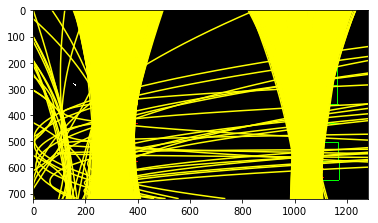

In [31]:
vid_output1 = 'outputvideo4.mp4'
clip2 = VideoFileClip("project_video.mp4")
vid_clip = clip2.fl_image(adlafi) #NOTE: this function expects color images!!
%time vid_clip.write_videofile(vid_output1, audio=False)

6548.06391344 2988.94180133
(720,)
shape pf leftx
(34873,)
2093.42857437 m 981.478439964 m
Curvature
1537.0


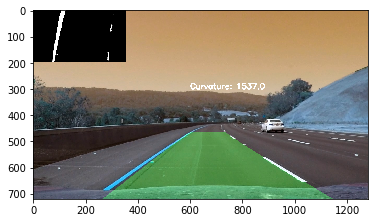

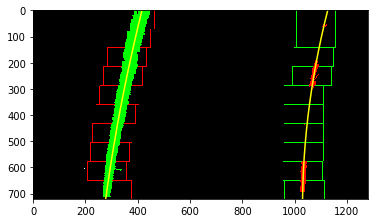

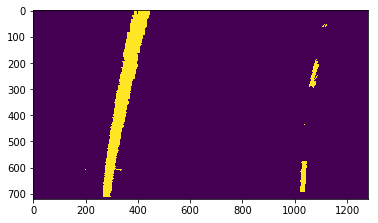

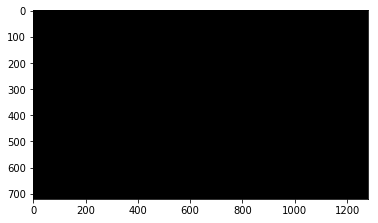

In [80]:
imag = cv2.imread('test_images/test3.jpg')
%matplotlib inline
a = adlafi(imag)
plt.imshow(a)
#plt.grid()
#curvature(a,imag,frame_process_window(imag))

In [ ]:

imag = mpimg.imread('test_images/test3.jpg')
plt.figure(1)
a = pit(imag)
alfplot(a)
plt.figure(2)
alfplot(imag)


In [ ]:
imag = cv2.imread('test_images/test4.jpg')
a = imag
b = a
c = pit(hls_select(b,2,(110,255)))
d = pit(color_thresh(b,2,(210,255)))
e = pit(abs_sobel_thresh(b,'x',(20,120)))
f = pit(dir_thresh(b,9,(.3,1)))
plt.figure(2)
plt.imshow(c,'gray')
plt.figure(3)
plt.imshow(d,'gray')
plt.figure(2)
plt.imshow(e,'gray')
plt.figure(1)
plt.imshow(f,'gray')

In [ ]:
a= np.array([1,2,3])
b = np.array([3,2,1])

In [ ]:
print(a)

In [ ]:
c = [a,b]

In [ ]:
print(c)

In [ ]:
print(sum(c))

In [ ]:
del c[0]

In [ ]:
print(c)

In [ ]:
print(c[0])